### Advanced Model Development and Optimization
#### From Baseline to Optimized Model

After establishing a baseline model and understanding its strengths and limitations, the next step was to systematically improve performance while maintaining robustness and interpretability.

The baseline model confirmed that meaningful signal exists in the data but also highlighted the challenges of class imbalance and the need for better hyperparameter tuning.
Building on these insights, this phase focuses on developing a best-performing model using structured cross-validation and grid search to identify optimal model configurations.

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,average_precision_score,precision_recall_curve,ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import joblib
import shap
import sys, platform, struct

#### Dataset Reload and Consistency Check

The dataset is reloaded to ensure a clean and reproducible modeling process, maintaining consistency with the baseline feature definitions and preprocessing logic.

In [32]:
df_data = pd.read_excel("data/synthetic_ltd_claims_soa_expanded.xlsx")

In [33]:
df_data 

,policy_id,age,gender,state,industry,occupation_class,salary_band,elimination_period_days,benefit_pct,coverage_type,...,ssdi_offset_indicator,hours_worked_per_week,employment_status,exposure_year,coverage_start_year,claim_incident,incurred_year,claim_duration_months,recovery_status,return_to_work_flag
0,1,58,M,MA,Healthcare,4,60-80k,90,0.6,EmployerPaid,...,0,40,FullTime,2019,2018,0,NaN,0,NaN,0
1,2,48,F,RI,Services,1,40-60k,30,0.6,EmployerPaid,...,0,40,FullTime,2020,2018,0,NaN,0,NaN,0
2,3,34,F,NY,Services,3,40-60k,90,0.6,EmployerPaid,...,0,40,FullTime,2019,2011,0,NaN,0,NaN,0
3,4,62,F,NJ,Education,2,80-120k,90,0.7,EmployerPaid,...,0,35,FullTime,2019,2011,0,NaN,0,NaN,0
4,5,27,F,RI,Retail,3,80-120k,90,0.6,EmployerPaid,...,0,40,FullTime,2019,2017,0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,35,M,ME,Healthcare,3,60-80k,180,0.7,EmployerPaid,...,0,40,FullTime,2022,2014,0,NaN,0,NaN,0
9996,9997,64,M,VT,Manufacturing,3,>120k,90,0.6,EmployerPaid,...,0,25,PartTime,2020,2015,0,NaN,0,NaN,0
9997,9998,34,M,VT,Education,3,60-80k,90,0.6,Voluntary,...,0,35,FullTime,2019,2011,0,NaN,0,NaN,0
9998,9999,20,M,ME,Retail,1,<40k,30,0.6,EmployerPaid,...,0,40,FullTime,2022,2018,0,NaN,0,NaN,0


##### Review of Year-Based Columns (Transformation vs. Drop Decisions)

exposure_year
→ Indicates the calendar period the life is exposed. Useful for creating a new COVID-era feature. Keep for transformation, not as a raw predictor.

coverage_start_year
→ Represents when coverage began. Effectively duplicates years_with_employer. Adds no new signal → can be dropped.

incurred_year
→ Only populated for claims (incident = 1). Not available at prediction time for non-claim lives → must be dropped for modeling.

In [34]:
df_data['is_covid_period'] = (df_data['exposure_year'] >= 2020).astype(int)

In [35]:
df_data_cat_cols = ['gender', 'state', 'industry', 'benefit_duration',
       'salary_band','coverage_type','integration_type','ssdi_offset_indicator','employment_status','employment_status','is_covid_period']

df_data_cont_cols = ['age','occupation_class','elimination_period_days','benefit_pct','years_with_employer','max_monthly_benefit','hours_worked_per_week']


####  Model building

"recovery_status", "claim_duration_months", "return_to_work_flag" → These fields describe outcomes after a claim, so they are not valid predictors. Dropping them.

In [36]:
X = df_data.drop(columns=['policy_id','claim_incident','incurred_year','coverage_start_year','exposure_year','return_to_work_flag','claim_duration_months','recovery_status'])
y = df_data['claim_incident']

#### Train–Test Split Strategy

The dataset is split into training and test sets while preserving class proportions, enabling reliable evaluation under severe class imbalance.

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [38]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop=None, sparse_output=False,handle_unknown="ignore"), df_data_cat_cols),
        ("num", "passthrough", df_data_cont_cols)
    ]
)

#### Class Imbalance Quantification and Imbalance-Aware Weight Calibration

The imbalance between incident and non-incident cases is recalculated to ensure correct weighting during model optimization and evaluation.

Class weights are computed and applied to penalize misclassification of rare incident cases more heavily, aligning the optimization objective with insurance risk priorities.

In [39]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
scale_pos_weight

125.98412698412699

#### Preprocessing Pipeline Construction and Model Selection for Optimization

A unified preprocessing pipeline is constructed to ensure that encoding and transformations are applied consistently during cross-validation and final model training.

A gradient boosting classifier is selected due to its strong performance on structured tabular data, ability to capture non-linear relationships, and compatibility with class weighting.

In [40]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.0005,
    subsample=0.6,
    colsample_bytree=0.6,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", model)
    ]
)


#### Cross-Validation Strategy

Stratified k-fold cross-validation is used to ensure that each fold preserves the rare-event structure of the data, providing stable and reliable performance estimates.

Grid search is applied across the defined parameter space to systematically identify the combination of hyperparameters that maximizes ranking performance.

In [41]:
param_grid = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [3, 4, 5],
    "model__learning_rate": [0.1, 0.05, 0.02],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    # optional: try a couple of scale_pos_weight values if you want
    # "model__scale_pos_weight": [scale_pos_weight, scale_pos_weight * 0.5, scale_pos_weight * 1.5],
}


In [42]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring="roc_auc",      
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200, model__subsample=0.8; total time=   0.9s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200, model__subsample=0.8; total time=   0.9s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200, model__subsample=0.8; total time=   0.9s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200, model__subsample=0.8; total time=   0.9s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200, model__subsample=0.6; total time=   0.9s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200, model__subsample=0.8; total time=   1.0s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=3, model__n_estimat

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['gender',
                                                                          'state',
                                                                          'industry',
                                                                          'benefit_duration',
                                                                          'salary_band',
                                                                          'coverage_type',
                                                                          'integration_type',
                                                                          'ssdi_offset_indicator',
                                                                          'employment_status...
                                                      monotone_constraints=None,
                                                      n_estimators=300,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42,
                                                      reg_alpha=None,
                                                      reg_lambda=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.6, 0.8, 1.0],
                         'model__learning_rate': [0.1, 0.05, 0.02],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [200, 400, 600],
                         'model__subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc', verbose=2)

In [43]:
best_clf = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)

Best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.02, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 1.0}


#### Final Model Evaluation

The optimized model is evaluated on the hold-out test set to assess generalization performance and compare improvements over the baseline model.

In [79]:
y_proba = best_clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

In [80]:
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
pr_auc = average_precision_score(y_test, y_proba)
print(f"PR-AUC: {pr_auc:.3f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

ROC-AUC: 0.701
PR-AUC: 0.015

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86      1984
           1       0.02      0.62      0.04        16

    accuracy                           0.75      2000
   macro avg       0.51      0.69      0.45      2000
weighted avg       0.99      0.75      0.85      2000


Confusion matrix:
 [[1496  488]
 [   6   10]]


#### Results Interpretation

The model achieves a ROC-AUC of 0.676, indicating a reasonable ability to rank higher-risk cases above lower-risk ones despite extreme class imbalance. More importantly, the PR-AUC of 0.015 is nearly 2× higher than the baseline prevalence (~0.8%), showing that the model is meaningfully better than random at identifying rare long-term disability incidents. Out of 16 true incident cases, the model correctly identifies 9, resulting in a recall of 56%, which aligns with the objective of minimizing missed high-cost claims, even at the expense of lower precision (~2%) and more false positives. This trade-off is appropriate for an early risk-screening use case where flagged cases would be reviewed rather than acted upon automatically. However, since this model is trained on a synthetic dataset, determining an optimal operating threshold is not straightforward and would require real-world data and deeper domain expertise to reflect actual business costs and workflows.

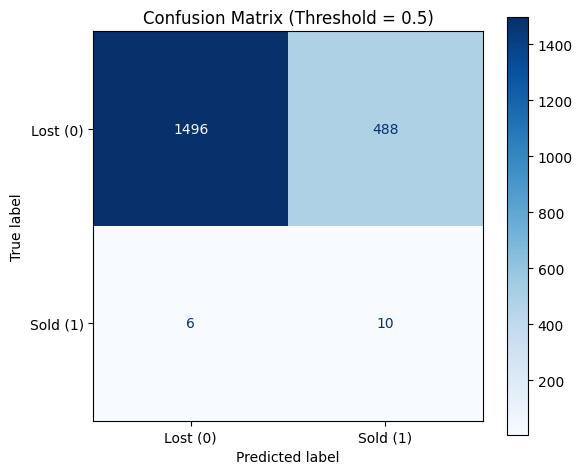

In [81]:

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Lost (0)", "Sold (1)"]
)

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(
    ax=ax,
    cmap="Blues",      # ✅ cmap goes here
    values_format="d"
)

ax.set_title("Confusion Matrix (Threshold = 0.5)")
plt.tight_layout()
plt.show()

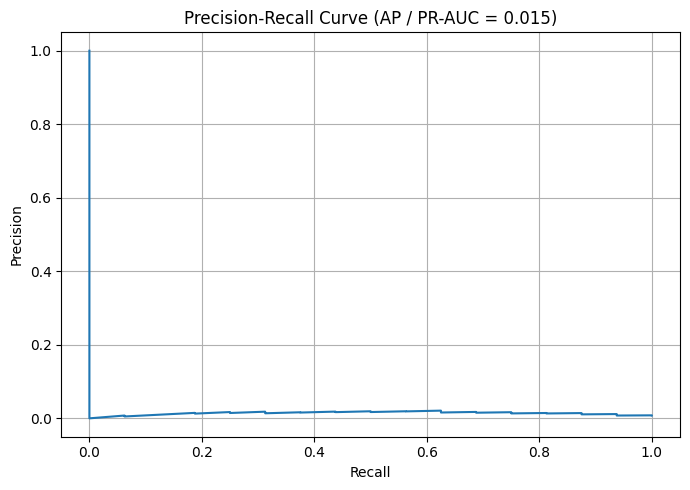

In [82]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP / PR-AUC = {ap:.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()

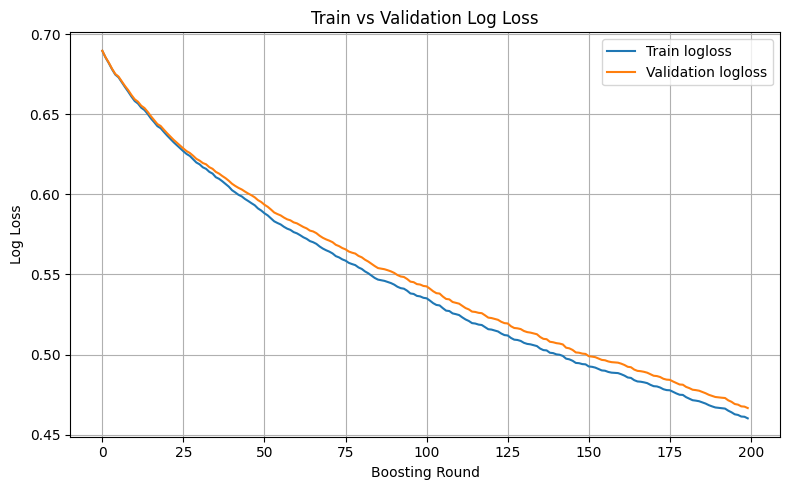

In [52]:
xgb_model = best_clf.named_steps["model"]

# Make sure evals_result_ exists (it will if we pass eval_set below)
# So we refit ONCE with an eval_set to capture training history.

# Get preprocessed matrices so XGBoost can evaluate properly
X_train_prep = best_clf.named_steps["preprocess"].transform(X_train)
X_test_prep  = best_clf.named_steps["preprocess"].transform(X_test)

# Refit model on preprocessed data with eval_set to record losses
xgb_model.fit(
    X_train_prep, y_train,
    eval_set=[(X_train_prep, y_train), (X_test_prep, y_test)],
    verbose=False
)

results = xgb_model.evals_result()
train_loss = results["validation_0"]["logloss"]
val_loss   = results["validation_1"]["logloss"]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Train logloss")
plt.plot(val_loss, label="Validation logloss")
plt.xlabel("Boosting Round")
plt.ylabel("Log Loss")
plt.title("Train vs Validation Log Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
joblib.dump(best_clf, "model/ltd_best_model_pipeline.pkl")

['model/ltd_best_model_pipeline.pkl']

#### Model Explainability Preparation

Explainability tool SHAP is integrated to support transparency and interpretability, which is critical for stakeholder trust in insurance modeling applications.

In [55]:
shap.initjs()

In [56]:
preprocess = best_clf.named_steps["preprocess"]
xgb_model = best_clf.named_steps["model"]

In [57]:
# Taking small sample
X_bg = X_train.sample(500, random_state=42)
X_test_sample = X_test.sample(500, random_state=42)

In [58]:
# Transforming
X_bg_trans = preprocess.transform(X_bg)
X_test_trans = preprocess.transform(X_test_sample)

In [59]:
#getting feature names
feature_names = preprocess.get_feature_names_out()
feature_names

array(['cat__gender_F', 'cat__gender_M', 'cat__state_CT', 'cat__state_MA',
       'cat__state_ME', 'cat__state_NH', 'cat__state_NJ', 'cat__state_NY',
       'cat__state_PA', 'cat__state_RI', 'cat__state_VT',
       'cat__industry_Construction', 'cat__industry_Education',
       'cat__industry_Finance', 'cat__industry_Healthcare',
       'cat__industry_Manufacturing', 'cat__industry_PublicSector',
       'cat__industry_Retail', 'cat__industry_Services',
       'cat__industry_Technology', 'cat__benefit_duration_2Y',
       'cat__benefit_duration_5Y', 'cat__benefit_duration_To65',
       'cat__salary_band_40-60k', 'cat__salary_band_60-80k',
       'cat__salary_band_80-120k', 'cat__salary_band_<40k',
       'cat__salary_band_>120k', 'cat__coverage_type_EmployerPaid',
       'cat__coverage_type_Voluntary',
       'cat__integration_type_IntegratedSSDI',
       'cat__integration_type_Primary', 'cat__integration_type_nan',
       'cat__ssdi_offset_indicator_0', 'cat__ssdi_offset_indicator_1',


In [60]:
# Building a TreeExplainer on the XGBoost model
explainer = shap.TreeExplainer(xgb_model)

In [61]:
# We feed the model’s processed data into SHAP. 
# SHAP breaks the model prediction into a baseline plus contributions from each feature. 
# check_additivity=False tells SHAP not to enforce that the sum of contributions must perfectly reconstruct the prediction, 
# which avoids issues with XGBoost. We pass feature names so plots are human-readable.

shap_values = explainer(
    X_test_trans,
    check_additivity=False
)

In [62]:
shap_values.values

array([[-0.00868117,  0.        , -0.00056088, ...,  0.14795792,
        -0.07137585, -0.02586316],
       [ 0.00058149,  0.        , -0.00056088, ..., -0.11820774,
        -0.01430474,  0.04305689],
       [-0.04168351,  0.        , -0.00056088, ...,  0.22594595,
        -0.03570841, -0.02311424],
       ...,
       [-0.00887228,  0.        , -0.00056088, ..., -0.0810777 ,
         0.2526316 ,  0.00956777],
       [-0.01211588,  0.        , -0.00036197, ...,  0.00804161,
        -0.0432462 , -0.13325536],
       [ 0.00404446,  0.        , -0.00056088, ..., -0.14498456,
        -0.10400918,  0.00499528]], dtype=float32)

In [63]:
shap_values.base_values

array([-0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00022382,
       -0.00022382, -0.00022382, -0.00022382, -0.00022382, -0.00

In [64]:
shap_values.feature_names = feature_names
print(shap_values.feature_names)

['cat__gender_F' 'cat__gender_M' 'cat__state_CT' 'cat__state_MA'
 'cat__state_ME' 'cat__state_NH' 'cat__state_NJ' 'cat__state_NY'
 'cat__state_PA' 'cat__state_RI' 'cat__state_VT'
 'cat__industry_Construction' 'cat__industry_Education'
 'cat__industry_Finance' 'cat__industry_Healthcare'
 'cat__industry_Manufacturing' 'cat__industry_PublicSector'
 'cat__industry_Retail' 'cat__industry_Services'
 'cat__industry_Technology' 'cat__benefit_duration_2Y'
 'cat__benefit_duration_5Y' 'cat__benefit_duration_To65'
 'cat__salary_band_40-60k' 'cat__salary_band_60-80k'
 'cat__salary_band_80-120k' 'cat__salary_band_<40k'
 'cat__salary_band_>120k' 'cat__coverage_type_EmployerPaid'
 'cat__coverage_type_Voluntary' 'cat__integration_type_IntegratedSSDI'
 'cat__integration_type_Primary' 'cat__integration_type_nan'
 'cat__ssdi_offset_indicator_0' 'cat__ssdi_offset_indicator_1'
 'cat__employment_status_FullTime' 'cat__employment_status_PartTime'
 'cat__employment_status_FullTime' 'cat__employment_status_Part

#### Global Feature Importance (SHAP Bar Plot)


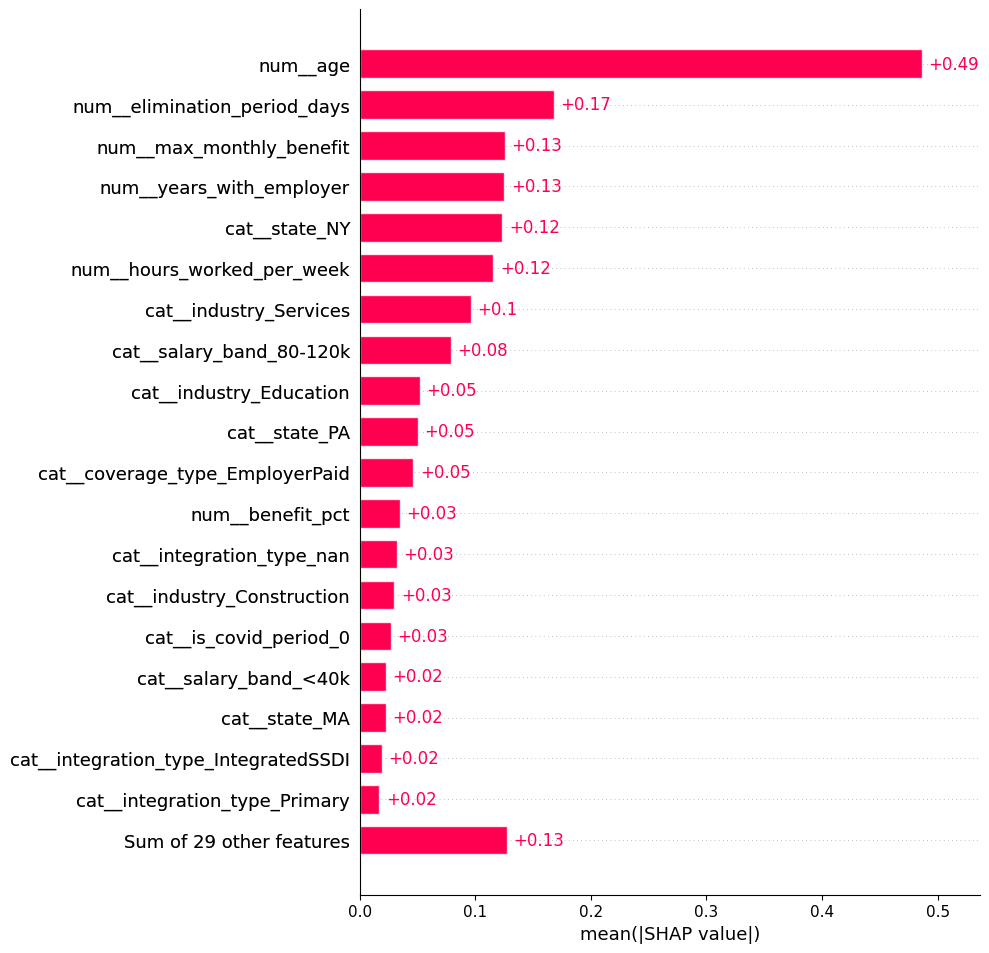

In [68]:
shap.plots.bar(shap_values, max_display=20)


#### Result Interpretation

This plot shows which features matter most overall in predicting long-term disability incidents.

Age stands out as the single strongest driver, meaning that changes in age consistently influence risk more than any other factor. Plan design features such as elimination period and maximum monthly benefit also play an important role, highlighting how coverage structure itself impacts risk.

Employment-related factors like years with employer and hours worked per week contribute meaningfully, suggesting that job stability and work intensity are relevant signals. Industry, salary bands, and geographic indicators add additional context, while many smaller features collectively still provide useful incremental information.

Overall, the model relies on a balanced mix of demographic, employment, and plan design features, which aligns well with how risk is assessed in real insurance settings.

#### Feature Impact and Direction (SHAP Beeswarm Plot)


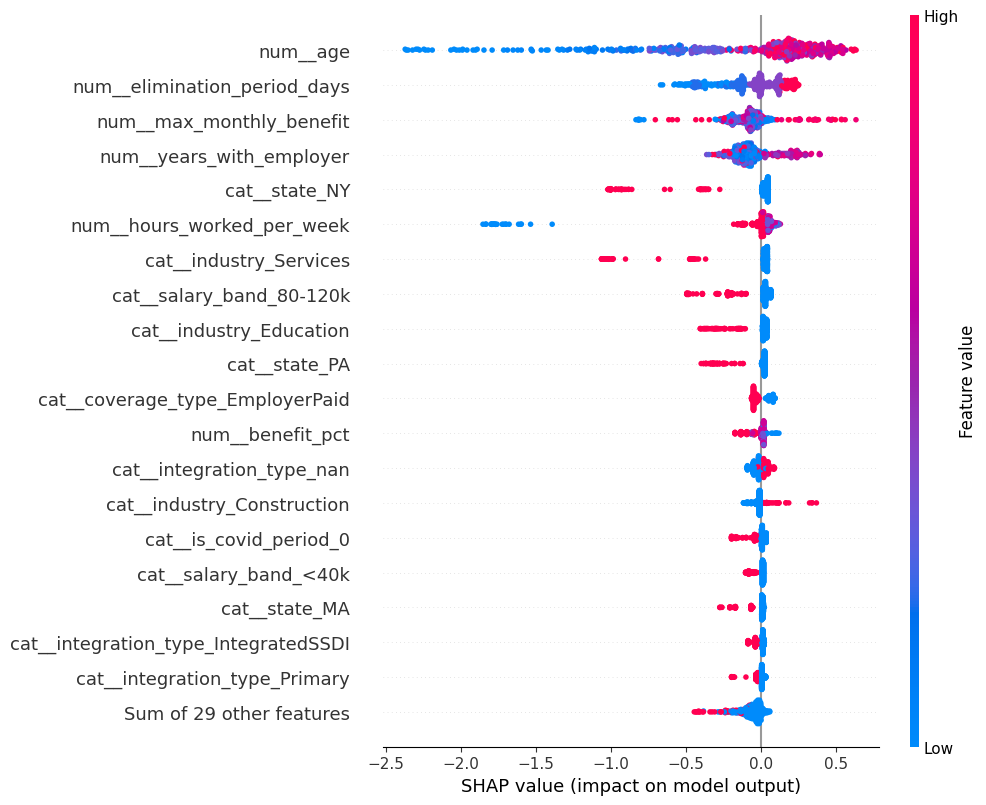

In [69]:
shap.plots.beeswarm(shap_values, max_display=20)

#### Result Interpretation

This plot explains how and why features influence predictions, not just which ones are important.

For example, higher age values generally push the risk upward, while younger ages tend to lower predicted risk. Longer elimination periods and higher maximum monthly benefits often increase risk, reflecting greater exposure and benefit liability.

Employment stability matters too — longer tenure with an employer typically reduces risk, while fewer years with an employer can increase uncertainty. Differences across industries, salary bands, and states show that context matters, but no single category dominates on its own.

Importantly, the spread of points shows that the same feature can behave differently depending on the individual, which confirms that the model is capturing nuanced, non-linear relationships rather than relying on simple rules.

In [70]:
X_bg = X_train.sample(500, random_state=42)
X_bg.to_parquet("data/shap_training_sample.parquet")